## Imports

In [1]:
import pathlib
import os
import os.path as osp
import sys
import argparse
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero

from utils.grid_search import grid_search
from utils.visualize import plot_loss, plot_train, plot_val, plot_test, plot_results
from utils.pick_hyperparams import pick_hyperparams

/home/atha/diploma/environ/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read the dataset

In [3]:
path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLens')
dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

#### Preprocess the dataset

In [4]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

#### Define the grid search space

In [5]:
layer_names = ["SAGE"]
encoder_min_num_layers=6
encoder_max_num_layers=6
decoder_min_num_layers=6
decoder_max_num_layers=6
epochs=300
logging_step=10
lrs = [0.011, 0.012, 0.013, 0.014]
skip_connections=[True]
losses = grid_search(
    layer_names=layer_names,
    encoder_min_num_layers=encoder_min_num_layers,
    encoder_max_num_layers=encoder_max_num_layers,
    decoder_min_num_layers=decoder_min_num_layers,
    decoder_max_num_layers=decoder_max_num_layers,
    epochs=epochs,
    data=data,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    device=device,
    logging_step=logging_step,
    lrs=lrs,
    skip_connections=skip_connections,
)

--->> ('SAGE', 6, True, 6, 0.011)


/home/atha/diploma/environ/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 010, Loss: 16.9222, Train: 3.3043, Val: 3.3176, Test: 3.3080
Epoch: 020, Loss: 15.9735, Train: 3.1861, Val: 3.1995, Test: 3.1898
Epoch: 030, Loss: 10.3502, Train: 2.1514, Val: 2.1787, Test: 2.1775
Epoch: 040, Loss: 7.0491, Train: 1.7828, Val: 1.8234, Test: 1.8133
Epoch: 050, Loss: 6.1585, Train: 1.5616, Val: 1.5881, Test: 1.5724
Epoch: 060, Loss: 6.2910, Train: 1.2677, Val: 1.2865, Test: 1.2836
Epoch: 070, Loss: 6.1279, Train: 1.3493, Val: 1.3857, Test: 1.3704
Epoch: 080, Loss: 6.1731, Train: 1.4290, Val: 1.4528, Test: 1.4469
Epoch: 090, Loss: 6.0985, Train: 1.4181, Val: 1.4177, Test: 1.4366
Epoch: 100, Loss: 6.1002, Train: 1.3782, Val: 1.4154, Test: 1.3982
Epoch: 110, Loss: 6.1009, Train: 1.3878, Val: 1.3826, Test: 1.3827
Epoch: 120, Loss: 6.0094, Train: 1.3593, Val: 1.3803, Test: 1.3654
Epoch: 130, Loss: 5.9519, Train: 1.4099, Val: 1.4093, Test: 1.3942
Epoch: 140, Loss: 5.9572, Train: 1.3016, Val: 1.3099, Test: 1.2998
Epoch: 150, Loss: 5.5773, Train: 1.3524, Val: 1.3409, Test:

#### Visualize

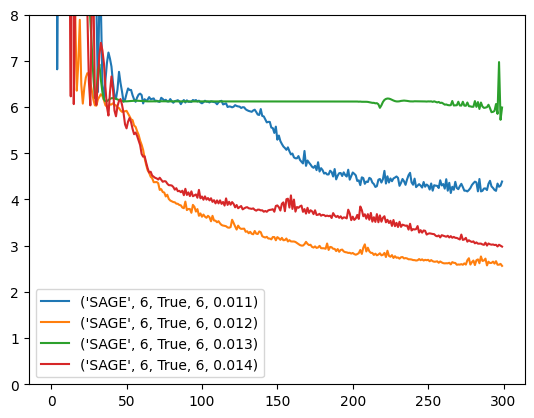

In [6]:
plot_loss(losses, ylim=8)

#### Save output

In [7]:
import json

specs = f"{layer_names}__encoder_{encoder_min_num_layers}_{encoder_max_num_layers}__decoder_{decoder_min_num_layers}_{decoder_max_num_layers}__{epochs}_epochs__{lrs}_lrs"
output_path = os.path.join("..", "results", specs+".json")
f = open(output_path, "w")
f.write(json.dumps({str(key): val for key, val in losses.items()}, indent=2))
f.close()

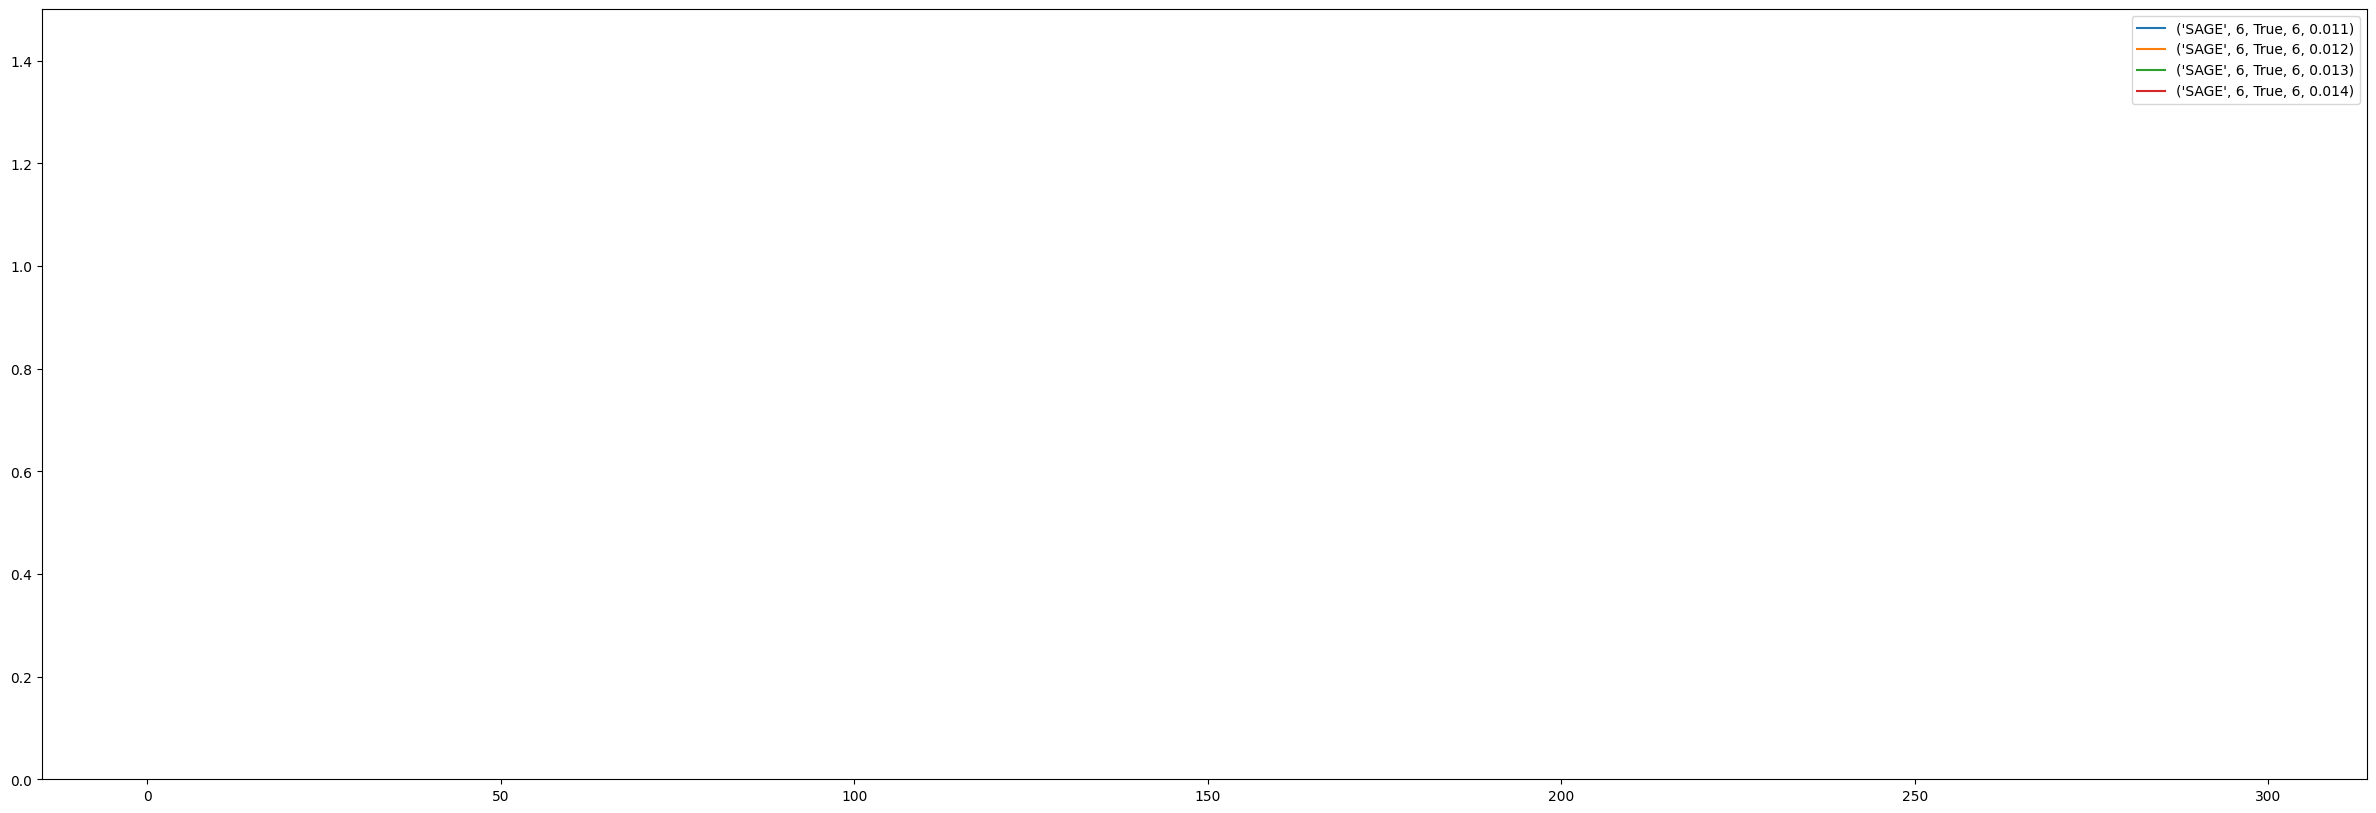

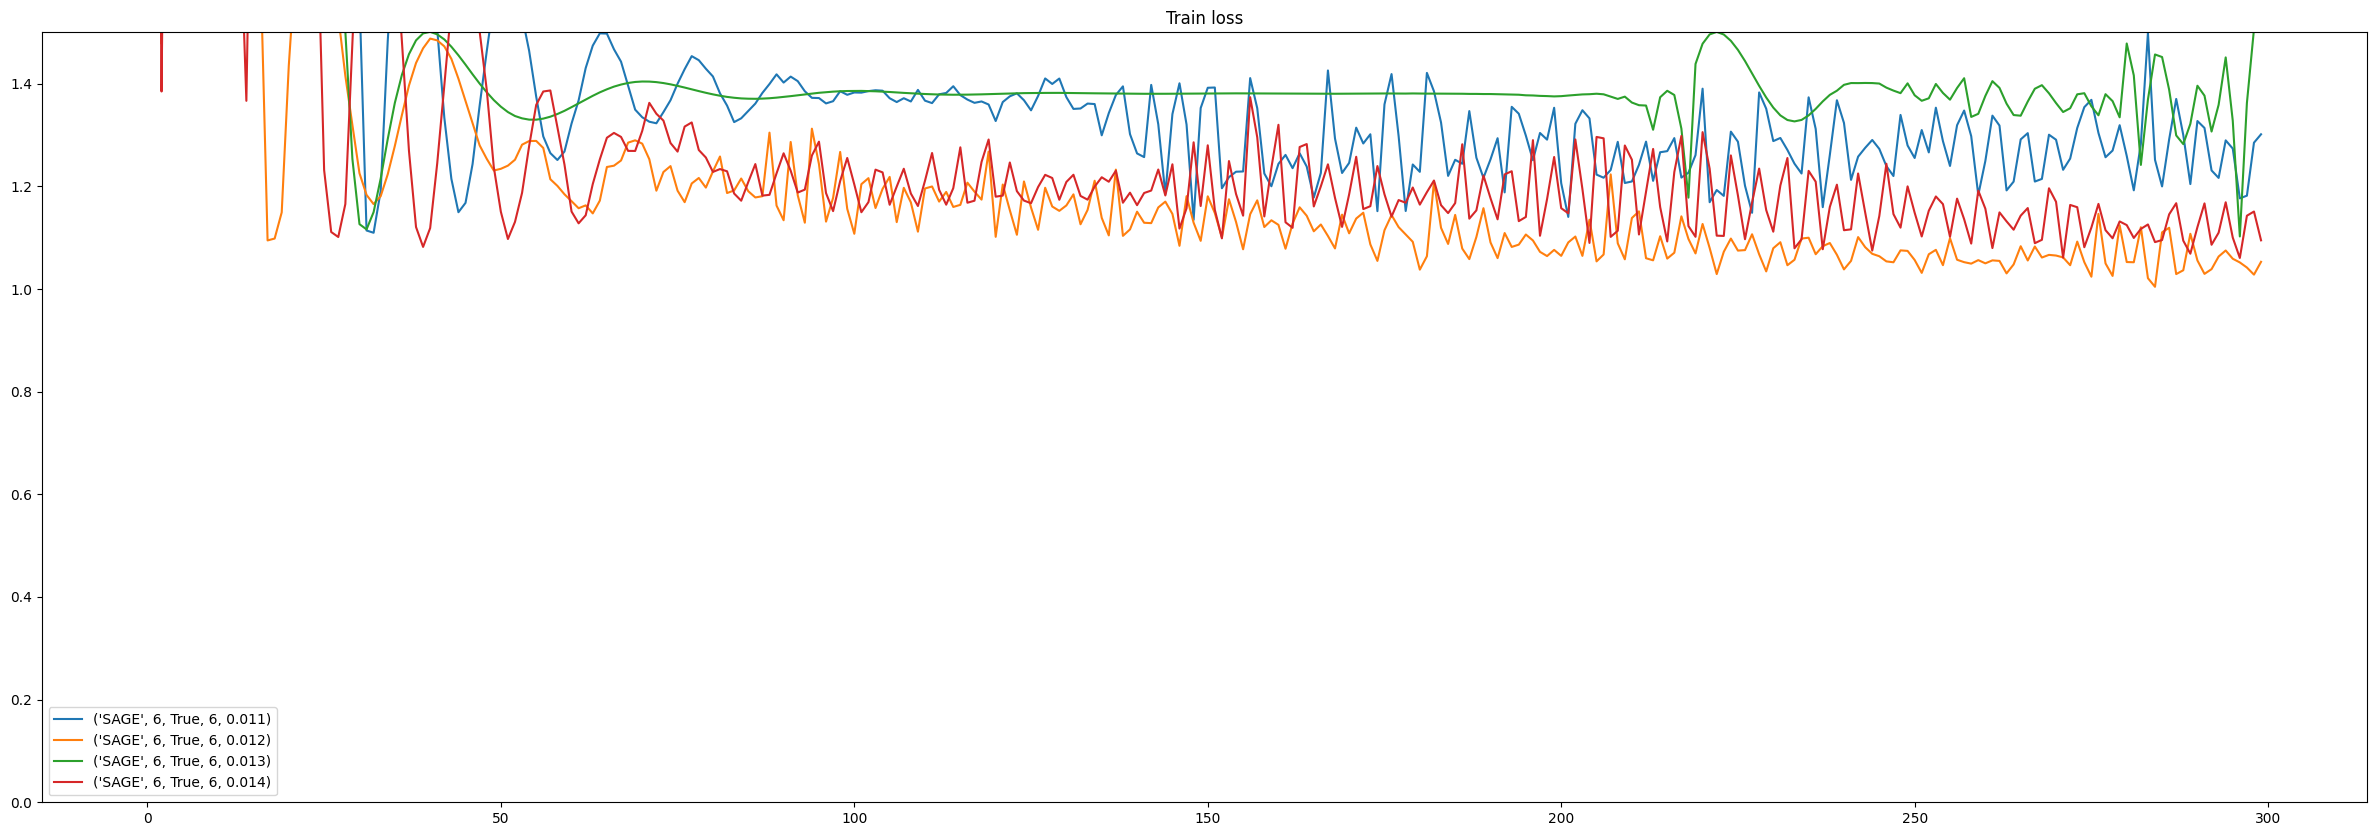

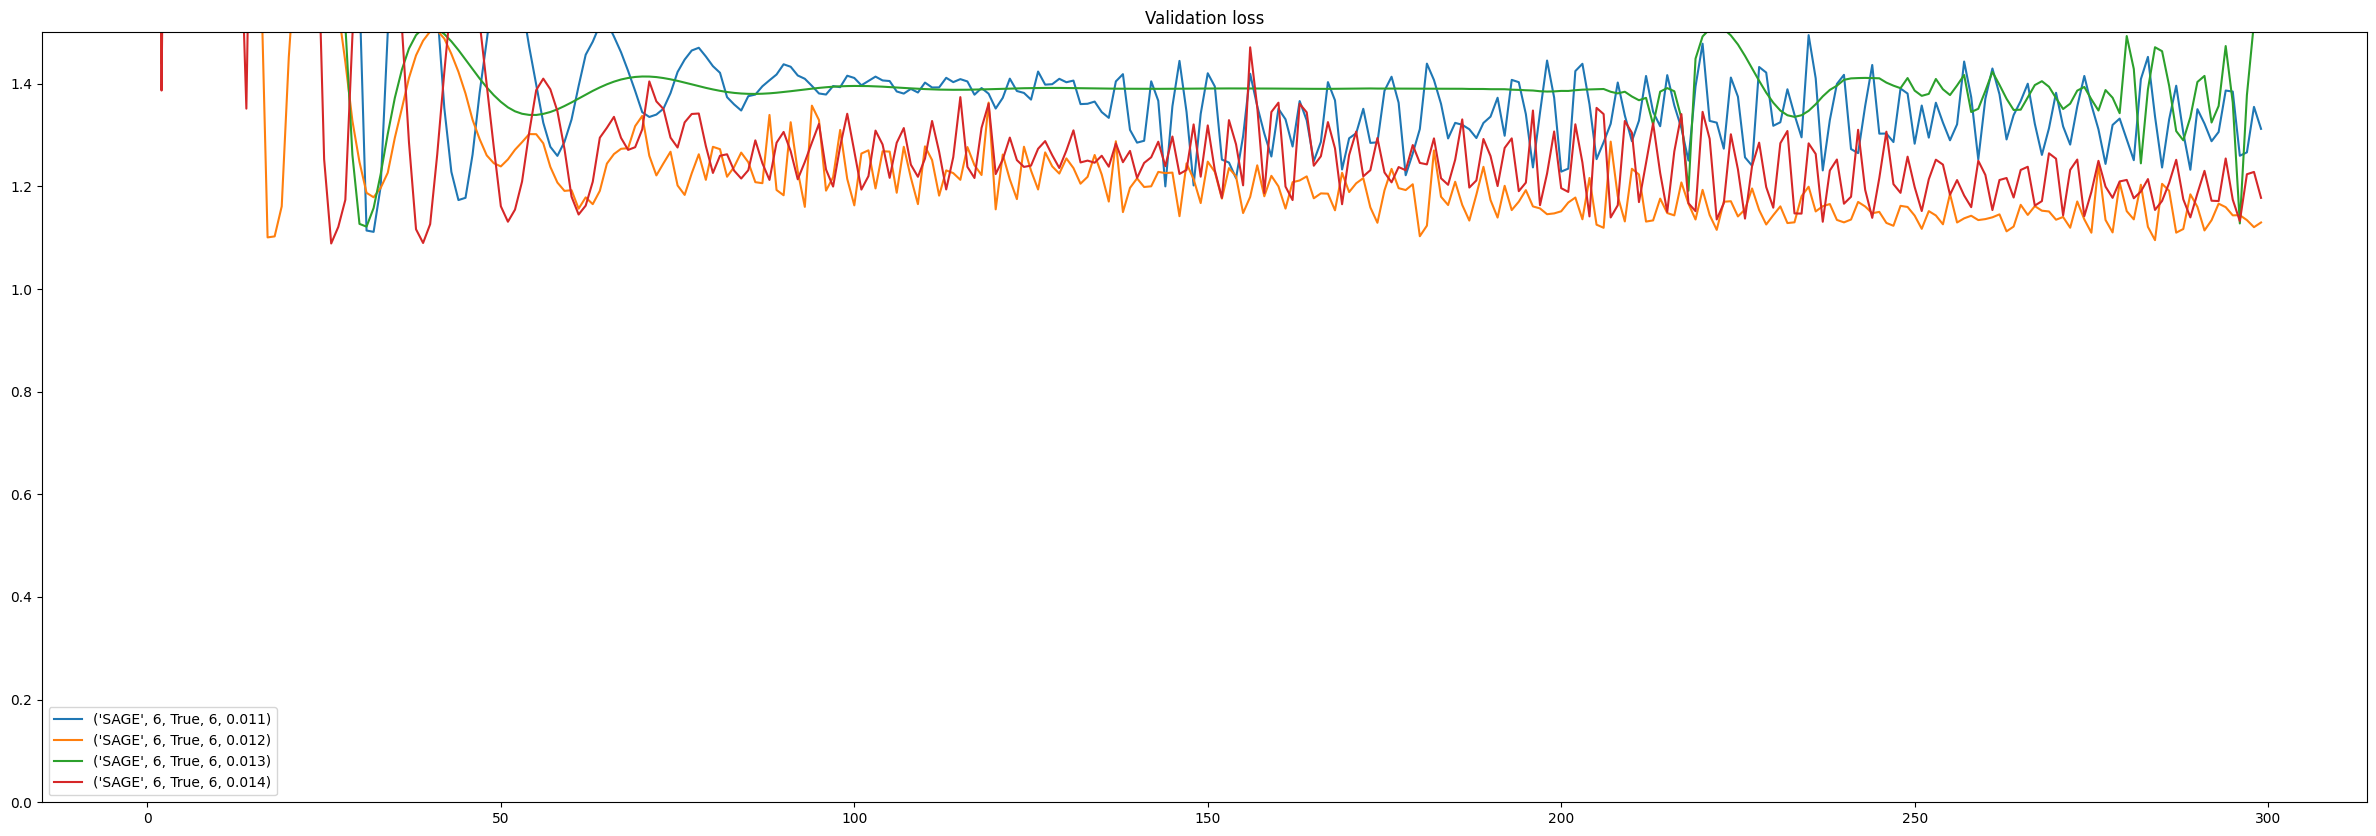

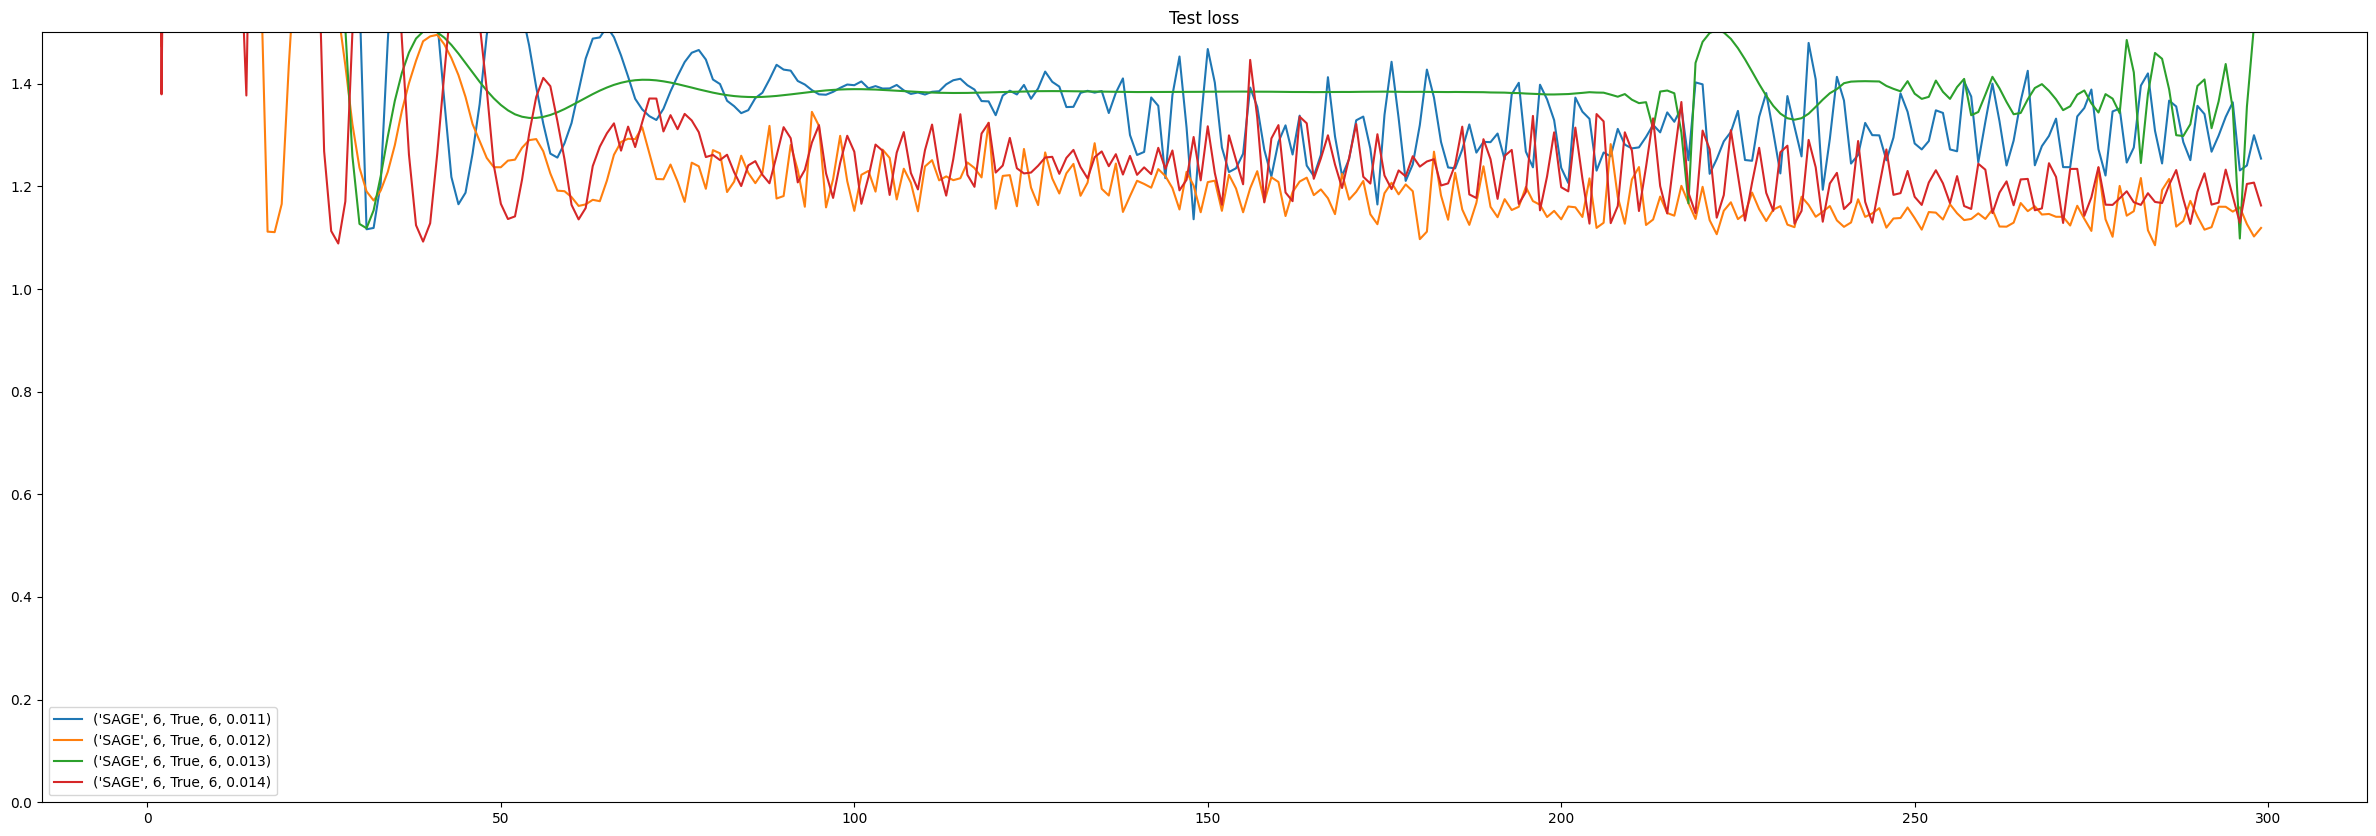

In [8]:
plot_results(output_path)

#### Pick the best hyper-parameters

In [9]:
pick_hyperparams(output_path)

Loss            Hyperparams
--------------  ---------------------------
Min Loss        ('SAGE', 6, True, 6, 0.012)
Min Train loss  ('SAGE', 6, True, 6, 0.012)
Min Val Loss    ('SAGE', 6, True, 6, 0.012)
Min Test Loss   ('SAGE', 6, True, 6, 0.012)
